
# Retail Analytics — Auto-Mapper Notebook (works with `train.csv`)

This notebook is designed to **work with any retail-like CSV** (your `train.csv`) by **auto-detecting** columns for:
- Order Date
- Category / Sub-Category
- Region / State / City
- Sales / Revenue
- Profit / Margin
- Quantity
- Discount

It then computes **KPIs**, creates **visualizations**, and saves **Tableau-ready CSVs** in an `exports/` folder.

> If a field is missing in your data (e.g., `Profit` isn't present), the notebook will **skip that chart** and continue.


## 1) Setup

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['axes.grid'] = True

CANDIDATES = [Path('train.csv'), Path('train.csv'), Path('train.csv')]
def find_data(cands):
    for p in cands:
        if p.exists():
            return p
    raise FileNotFoundError("Place your CSV at /mnt/data/train.csv or ./data/train.csv")

DATA_PATH = find_data(CANDIDATES)
EXPORT_DIR = Path('exports'); EXPORT_DIR.mkdir(exist_ok=True, parents=True)

DATA_PATH


WindowsPath('train.csv')

## 2) Load & Standardize Columns

In [2]:

df = pd.read_csv(DATA_PATH, encoding='utf-8', engine='python')
orig_cols = list(df.columns)

def std(s):
    s = str(s).strip().lower()
    s = s.replace('\n',' ').replace('\r',' ')
    s = re.sub(r'\s+', ' ', s)
    return s

cols_std = [std(c) for c in df.columns]
df.columns = cols_std
print("Original columns -> standardized:")
for o, s in zip(orig_cols, cols_std):
    print(f" - {o} -> {s}")
df.head()


Original columns -> standardized:
 - Row ID -> row id
 - Order ID -> order id
 - Order Date -> order date
 - Ship Date -> ship date
 - Ship Mode -> ship mode
 - Customer ID -> customer id
 - Customer Name -> customer name
 - Segment -> segment
 - Country -> country
 - City -> city
 - State -> state
 - Postal Code -> postal code
 - Region -> region
 - Product ID -> product id
 - Category -> category
 - Sub-Category -> sub-category
 - Product Name -> product name
 - Sales -> sales


,row id,order id,order date,ship date,ship mode,customer id,customer name,segment,country,city,state,postal code,region,product id,category,sub-category,product name,sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


## 3) Auto-Map Important Columns

In [3]:

def find_first(patterns):
    for c in df.columns:
        for p in patterns:
            if re.search(p, c):
                return c
    return None

colmap = {
    'order_date': find_first([r'order.*date', r'date']),  # prefer 'order date' then any 'date'
    'category':   find_first([r'^category$', r'prod.*category', r'cat$']),
    'subcat':     find_first([r'sub[-_ ]?cat', r'sub.*category']),
    'region':     find_first([r'^region$', r'market', r'sales region']),
    'state':      find_first([r'^state$', r'province']),
    'city':       find_first([r'^city$', r'town']),
    'sales':      find_first([r'^sales$', r'revenue', r'amount', r'line.*total', r'total.*price']),
    'profit':     find_first([r'^profit$', r'margin', r'gain']),
    'quantity':   find_first([r'quantity', r'qty', r'units']),
    'discount':   find_first([r'discount', r'disc']),
    'price':      find_first([r'price', r'unit.*price', r'rate'])
}
colmap


{'order_date': 'order date',
 'category': 'category',
 'subcat': 'sub-category',
 'region': 'region',
 'state': 'state',
 'city': 'city',
 'sales': 'sales',
 'profit': None,
 'quantity': None,
 'discount': None,
 'price': None}

**Detected mapping** (None means not found). The notebook adapts accordingly.

In [4]:
colmap

{'order_date': 'order date',
 'category': 'category',
 'subcat': 'sub-category',
 'region': 'region',
 'state': 'state',
 'city': 'city',
 'sales': 'sales',
 'profit': None,
 'quantity': None,
 'discount': None,
 'price': None}

## 4) Parse Dates & Time Features

In [5]:

if colmap['order_date']:
    df['order_date'] = pd.to_datetime(df[colmap['order_date']], errors='coerce')
    df = df.dropna(subset=['order_date']).copy()
    df['year'] = df['order_date'].dt.year
    df['month'] = df['order_date'].dt.month
    df['year_month'] = df['order_date'].dt.to_period('M').astype(str)
else:
    print("WARNING: No order date field detected. Time-based charts will be skipped.")


## 5) Clean Numerics & Derive Sales if needed

In [6]:

def to_num(s):
    return pd.to_numeric(pd.Series(s).astype(str).str.replace('[^0-9.-]','', regex=True), errors='coerce')

# Convert numeric-like fields
for key in ['sales','profit','quantity','discount','price']:
    if colmap[key]:
        df[key] = to_num(df[colmap[key]])
    else:
        df[key] = np.nan

# If sales missing but have price * quantity, derive it
if df['sales'].isna().all() and not df['price'].isna().all() and not df['quantity'].isna().all():
    df['sales'] = df['price'] * df['quantity']

df.head()


,row id,order id,order date,ship date,ship mode,customer id,customer name,segment,country,city,...,product name,sales,order_date,year,month,year_month,profit,quantity,discount,price
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bush Somerset Collection Bookcase,261.9600,2017-08-11,2017,8,2017-08,NaN,NaN,NaN,NaN
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,2017-08-11,2017,8,2017-08,NaN,NaN,NaN,NaN
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Self-Adhesive Address Labels for Typewriters b...,14.6200,2017-12-06,2017,12,2017-12,NaN,NaN,NaN,NaN
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Bretford CR4500 Series Slim Rectangular Table,957.5775,2016-11-10,2016,11,2016-11,NaN,NaN,NaN,NaN
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Eldon Fold 'N Roll Cart System,22.3680,2016-11-10,2016,11,2016-11,NaN,NaN,NaN,NaN


## 6) KPIs

In [7]:

kpis = {}
if not df['sales'].isna().all():
    kpis['Revenue'] = float(df['sales'].sum())
if not df['profit'].isna().all():
    kpis['Profit'] = float(df['profit'].sum())
if not df['sales'].isna().all() and 'year_month' in df:
    orders = df.groupby('year_month').size().shape[0]
    kpis['Avg Order Value'] = float(df['sales'].sum() / max(1, orders))
kpis['Total Rows'] = int(len(df))
kpis


{'Revenue': 872363.1236,
 'Avg Order Value': 18174.231741666666,
 'Total Rows': 3959}

## 7) Monthly Sales Trend

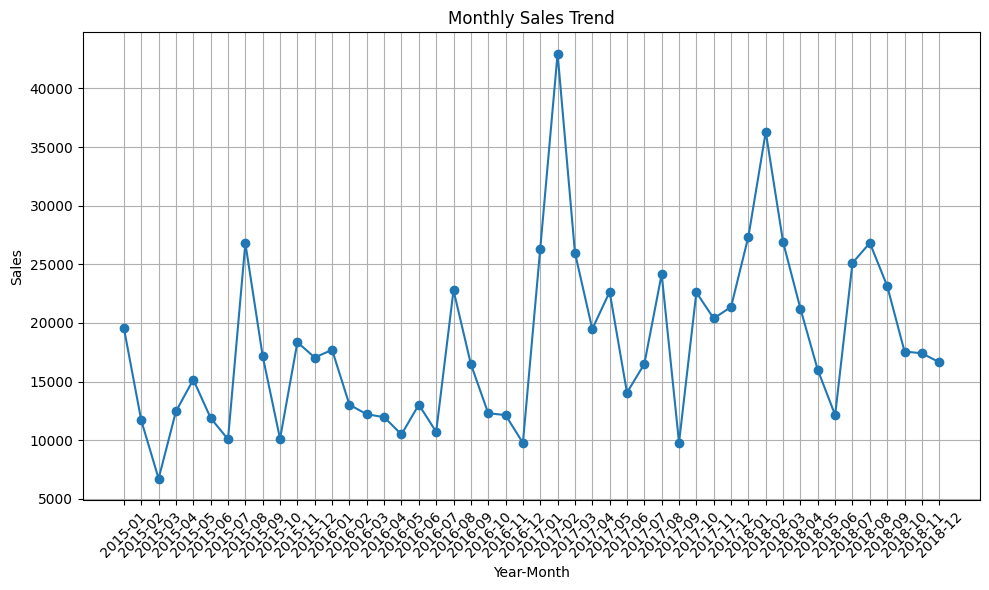

In [8]:

if 'year_month' in df and not df['sales'].isna().all():
    monthly = df.groupby('year_month')['sales'].sum().reset_index().sort_values('year_month')
    monthly.to_csv(EXPORT_DIR/'monthly_sales.csv', index=False)
    fig, ax = plt.subplots()
    ax.plot(monthly['year_month'], monthly['sales'], marker='o')
    ax.set_title('Monthly Sales Trend')
    ax.set_xlabel('Year-Month'); ax.set_ylabel('Sales')
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()
else:
    print("Skipped: need order_date and sales.")


## 8) Category and Sub-Category Performance

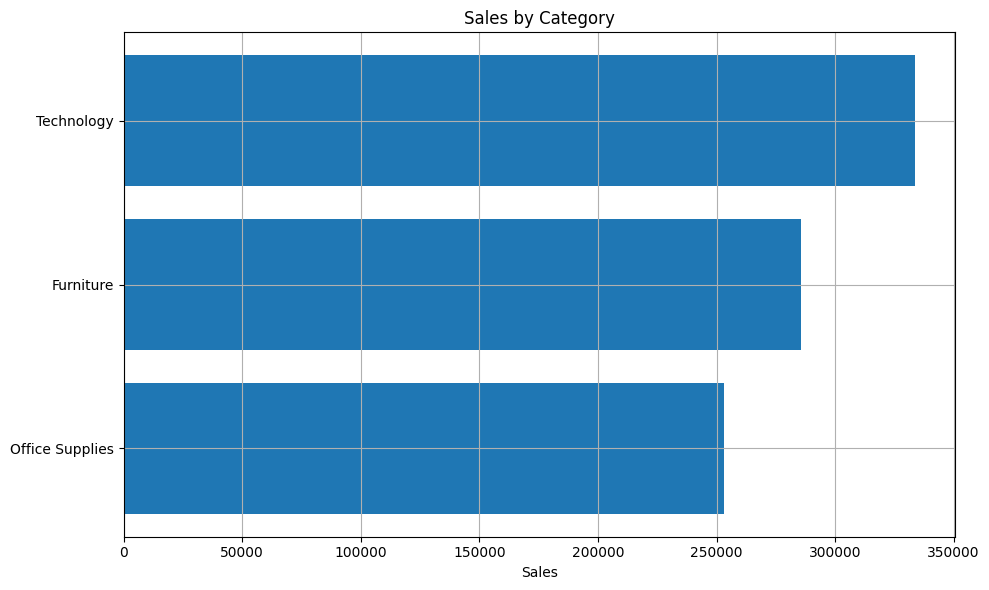

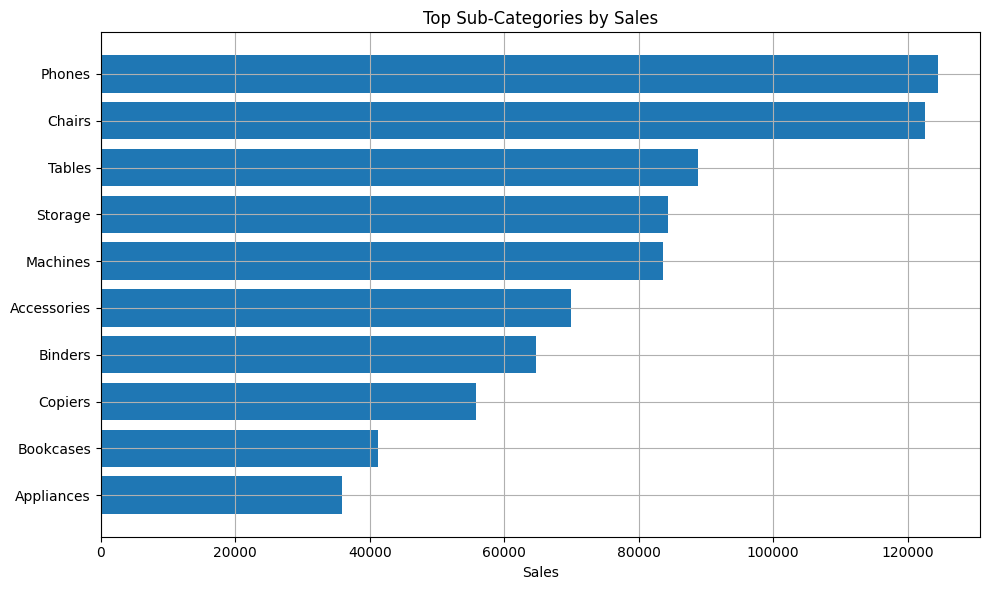

In [9]:

if colmap['category'] and not df['sales'].isna().all():
    cat = df.groupby(colmap['category'])['sales'].sum().reset_index().sort_values('sales', ascending=False)
    cat.to_csv(EXPORT_DIR/'sales_by_category.csv', index=False)
    fig, ax = plt.subplots(); ax.barh(cat[colmap['category']][::-1], cat['sales'][::-1])
    ax.set_title('Sales by Category'); ax.set_xlabel('Sales'); plt.tight_layout(); plt.show()
else:
    print("Skipped category chart (need category & sales).")

if colmap['category'] and colmap['subcat'] and not df['sales'].isna().all():
    sub = df.groupby([colmap['category'], colmap['subcat']])['sales'].sum().reset_index().sort_values('sales', ascending=False)
    sub.to_csv(EXPORT_DIR/'sales_by_subcategory.csv', index=False)
    top = sub.head(10)
    fig, ax = plt.subplots(); ax.barh(top[colmap['subcat']][::-1], top['sales'][::-1])
    ax.set_title('Top Sub-Categories by Sales'); ax.set_xlabel('Sales'); plt.tight_layout(); plt.show()
else:
    print("Skipped sub-category chart (need category, sub-category & sales).")


## 9) Sales & Profit by Region/State

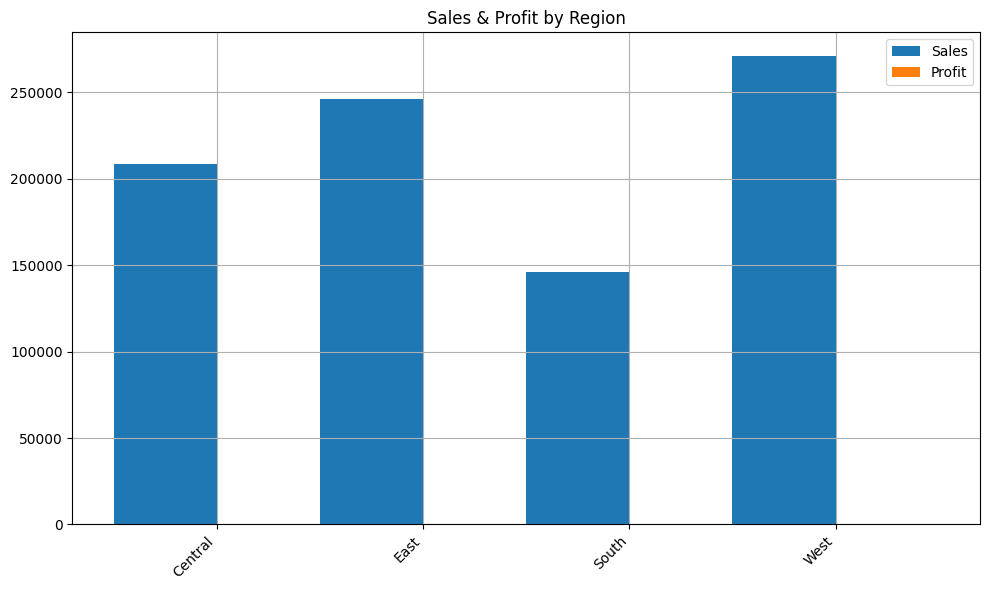

In [10]:

geo_dim = colmap['region'] or colmap['state'] or colmap['city']
if geo_dim and (not df['sales'].isna().all() or not df['profit'].isna().all()):
    agg = df.groupby(geo_dim)[['sales','profit']].sum(min_count=1).reset_index().fillna(0)
    agg.to_csv(EXPORT_DIR/'sales_profit_by_geo.csv', index=False)
    fig, ax = plt.subplots()
    x = np.arange(len(agg))
    ax.bar(x-0.25, agg['sales'], width=0.5, label='Sales' if not agg['sales'].isna().all() else 'Sales (n/a)')
    ax.bar(x+0.25, agg['profit'], width=0.5, label='Profit' if not agg['profit'].isna().all() else 'Profit (n/a)')
    ax.set_xticks(x, agg[geo_dim], rotation=45, ha='right')
    ax.set_title(f"Sales & Profit by {geo_dim.title()}"); ax.legend()
    plt.tight_layout(); plt.show()
else:
    print("Skipped geo chart (need a geo column and sales/profit).")


## 10) Simple 3-Month Moving Average Forecast

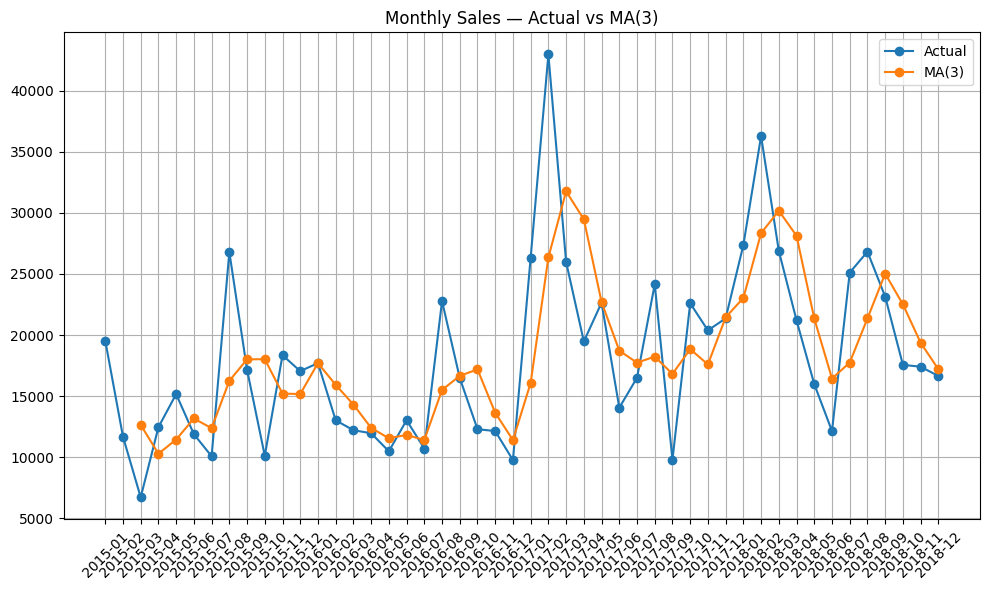

In [11]:

if 'year_month' in df and not df['sales'].isna().all():
    monthly = df.groupby('year_month')['sales'].sum().reset_index().sort_values('year_month')
    monthly['sales'] = monthly['sales'].astype(float)
    monthly['MA3'] = monthly['sales'].rolling(3).mean()
    monthly.to_csv(EXPORT_DIR/'monthly_sales_ma3.csv', index=False)
    fig, ax = plt.subplots()
    ax.plot(monthly['year_month'], monthly['sales'], marker='o', label='Actual')
    ax.plot(monthly['year_month'], monthly['MA3'], marker='o', label='MA(3)')
    ax.set_title('Monthly Sales — Actual vs MA(3)'); ax.legend()
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()
else:
    print("Skipped forecast (need order_date and sales).")


## 11) Inventory ABC & Reorder Point (if quantity available)

In [12]:

if colmap['subcat'] and not df['quantity'].isna().all():
    item = colmap['subcat']
    sales_by_item = df.groupby(item)['sales'].sum(min_count=1).fillna(0).sort_values(ascending=False).reset_index()
    sales_by_item['pct'] = sales_by_item['sales'] / max(1, sales_by_item['sales'].sum())
    sales_by_item['cum_pct'] = sales_by_item['pct'].cumsum()
    def abc(p):
        if p <= 0.8: return 'A'
        if p <= 0.95: return 'B'
        return 'C'
    sales_by_item['ABC'] = sales_by_item['cum_pct'].apply(abc)
    qty_m = df.groupby(['year_month', item])['quantity'].sum().reset_index() if 'year_month' in df else df.groupby(item)['quantity'].sum().reset_index().rename(columns={'quantity':'Quantity'})
    if 'year_month' in df:
        stats = qty_m.groupby(item)['quantity'].agg(['mean','std']).reset_index().rename(columns={'mean':'DemandMean','std':'DemandStd'})
    else:
        stats = qty_m.rename(columns={'Quantity':'DemandMean'}); stats['DemandStd'] = 0.0
    inv = sales_by_item.merge(stats, on=item, how='left')
    lead_time = 2; z = 1.65
    inv['SafetyStock'] = z * (inv['DemandStd'].fillna(0)) * np.sqrt(lead_time)
    inv['ReorderPoint'] = inv['DemandMean'].fillna(0) * lead_time + inv['SafetyStock']
    inv.to_csv(EXPORT_DIR/'inventory_helper.csv', index=False)
    inv.head()
else:
    print("Skipped inventory helper (need sub-category and quantity).")


Skipped inventory helper (need sub-category and quantity).
